In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras import backend as K

fatal: destination path 'pylops_seismic_cs' already exists and is not an empty directory.
the shape is:  (900, 101, 14)


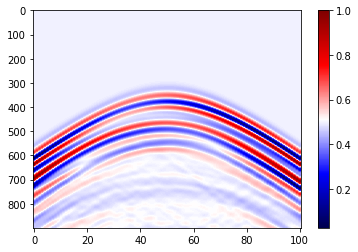

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
!git clone https://github.com/PAULGOYES/pylops_seismic_cs.git
#coil_synt_cspread
Data = np.load('pylops_seismic_cs/syn3D_cross-spread2.npy')[:900,:,:14]
plt.figure()
plt.imshow(Data[:,:,13],aspect='auto',cmap='seismic')
plt.colorbar()


print('the shape is: ', Data.shape)

In [ ]:
indexDel = [3,5,7,10,12]
IndexSam = [0,1,2,4,6,8,9,11,13]
#idx_Train = indexx[:int(50*50*0.2)]
#idx_Val = indexx[int(50*50*0.2):]
#print(idx)
timesampling = np.linspace(0,1,Data.shape[0])
tracesampling = np.linspace(0,1,Data.shape[1])
shotsampling = np.linspace(0,1,Data.shape[2])
TRACEarray, TIMEarray, SHOTarray = np.meshgrid(tracesampling,timesampling,shotsampling)

COORXYZval = np.stack((TRACEarray.ravel(),TIMEarray.ravel(),SHOTarray.ravel()),axis=-1)

timecoor = np.delete(TIMEarray,indexDel,axis=-1)
tracecoor = np.delete(TRACEarray,indexDel,axis=-1)
shotcoor = np.delete(SHOTarray,indexDel,axis=-1)

COORXYZtrain = np.stack((tracecoor.ravel(),timecoor.ravel(),shotcoor.ravel()),axis=-1)
OUTPUTtrain   = np.delete(Data,indexDel,axis=-1).reshape(-1,1)

print(COORXYZtrain.shape)
print(OUTPUTtrain.shape)




(818100, 3)
(818100, 1)


In [ ]:
timesamplingval = np.delete(TIMEarray,IndexSam,axis=-1)
tracesamplingval = np.delete(TRACEarray,IndexSam,axis=-1)
shotsamplingval = np.delete(SHOTarray,IndexSam,axis=-1)

COORXYZvaldel = np.stack((tracesamplingval.ravel(),timesamplingval.ravel(),shotsamplingval.ravel()),axis=-1)
OUTPUTval =  np.delete( Data,IndexSam,axis=-1).reshape(-1,1)

print(COORXYZvaldel.shape)
print(OUTPUTval.shape)


(454500, 3)
(454500, 1)


Text(0.5, 0, 'SHOT')

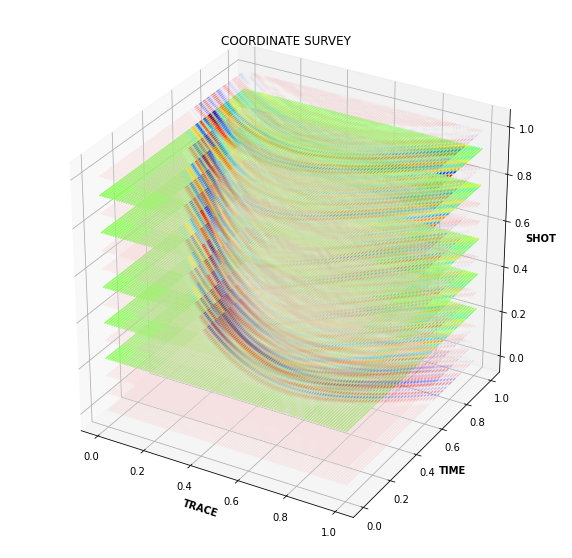

In [ ]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection ="3d")
scttssim=ax.scatter3D(COORXYZtrain[:,0],COORXYZtrain[:,1],COORXYZtrain[:,2], c = OUTPUTtrain,s = 0.1, cmap='seismic',alpha=0.1)
scttssim=ax.scatter3D(COORXYZvaldel[:,0],COORXYZvaldel[:,1],COORXYZvaldel[:,2], c = OUTPUTval,s = 0.1,cmap='jet')
plt.title('COORDINATE SURVEY')
ax.set_xlabel('TRACE', fontweight ='bold')
ax.set_ylabel('TIME', fontweight ='bold')
ax.set_zlabel('SHOT', fontweight ='bold')

In [ ]:
import numpy as np
def input_mapping(x, L,log_sampling=True): 
  	frequency_bands= None
  	if log_sampling:
  		frequency_bands = 2.0**np.linspace(0.0,
  		L-1,
  		L)
  	else:
  		frequency_bands = np.linspace(
  		2.0**0.0,
  		2.0**(L-1),
  		L)
  	encoding = []
  	for idx,freq in enumerate(frequency_bands):
  		for fun in [np.sin, np.cos]:
  			encoding.append(fun(x*freq))
  	return np.concatenate(encoding)

xx = np.array([[0.2,0.25,0.1],[0.1,0.8,0.3]])
a = input_mapping(xx.T,L=1,log_sampling=True)
#ejecute aqui un ejemplo
print(a.shape)

(6, 2)


- loglinear sampling  $\kappa = 2^{i-1} \pi \mathbf{v} \}_{i=1}^{L}$
- linear sampling $\kappa = \mathbf{v} \pi (i)/2  \}_{i=1}^{L}$

In [ ]:
def auxfun(x,L,sampling):
  temp=[]
  if sampling == 'loglinear':
    kappa = np.pi*2.0**np.arange(L)
  elif sampling == 'linear':
  	kappa = 0.5*np.pi*np.arange(1,L+1)#np.linspace(2.0**0, 2.0**(L-1),L)
  for k in kappa:
      for fun in [np.sin, np.cos]:
        temp.append(fun(x*k))
  return temp

def auxfun2(x,L,sampling):
  xaxisPE = auxfun(x[0],L[0],sampling)
  yaxisPE = auxfun(x[1],L[1],sampling)
  zaxisPE = auxfun(x[2],L[2],sampling)
  return np.concatenate((xaxisPE,yaxisPE,zaxisPE),axis=0)


def input_mapping_aniso(x,L,sampling='loglinear'):
  out = np.zeros((x.shape[0],2*np.sum(L)))
  for i in range(x.shape[0]):
    out[i,:] = auxfun2(x[i,:],L,sampling)
  return out
 
a = input_mapping_aniso(xx,L=[2,1,1],sampling='loglinear')
print(a)


[[ 0.58778525  0.80901699  0.95105652  0.30901699  0.70710678  0.70710678
   0.30901699  0.95105652]
 [ 0.30901699  0.95105652  0.58778525  0.80901699  0.58778525 -0.80901699
   0.80901699  0.58778525]]


## Train networks with different input mappings

We compare the following mappings $\gamma (\mathbf{v})$.

- No mapping: $\gamma(\mathbf{v})= \mathbf{v}$. 

- Basic mapping: $\gamma(\mathbf{v})=\left[ \cos(\kappa \mathbf{v}),\sin(\kappa \mathbf{v}) \right]^\mathrm{T}$. 

- Positional encoding: $\gamma(\mathbf{v})=\left[ \ldots, \cos(\kappa_j \mathbf{v}),\sin(\kappa_j \mathbf{v}), \ldots \right]^\mathrm{T}$ for $j = 0, \ldots, L-1$

- L-variational positional encoding: $\gamma(\mathbf{x,y,z})=
\begin{bmatrix}
\left[ \ldots, \cos(\kappa_i \mathbf{x}),\sin(\kappa_i \mathbf{x}), \ldots \right]^\mathrm{T} for \ i = 0, \ldots, L_\mathbf{x} -1  \\ 
\left[ \ldots, \cos(\kappa_j \mathbf{y}),\sin(\kappa_j \mathbf{y}), \ldots \right]^\mathrm{T} for \ j = 0, \ldots, L_\mathbf{y} -1  \\
\left[ \ldots, \cos(\kappa_k \mathbf{z}),\sin(\kappa_k \mathbf{z}), \ldots \right]^\mathrm{T} for \ k = 0, \ldots, L_\mathbf{z} -1 
\end{bmatrix}$

- Gaussian Fourier feature mapping: $\gamma(\mathbf{v})= \left[ \cos(2 \pi \mathbf B \mathbf{v}), \sin(2 \pi \mathbf B \mathbf{v}) \right]^\mathrm{T}$, 
where each entry in $\mathbf B \in \mathbb R^{m \times d}$ is sampled from $\mathcal N(0,\sigma^2)$, where $m$ is the number of channels and $d$ is the input dimension.

In [ ]:
def input_mappingB(x, B): 
  if B is None:
    return x
  else:
    x_proj = (x) @ B.T
    #print(x_proj.shape)
    return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)

print(input_mappingB(xx,np.eye(3)))


[[0.19866933 0.24740396 0.09983342 0.98006658 0.96891242 0.99500417]
 [0.09983342 0.71735609 0.29552021 0.99500417 0.69670671 0.95533649]]


In [ ]:
def createMLPFFM(input_dim, channels, Hiddenlayers, output_dim, L=None):
  model = keras.Sequential()
  if L is None:
    print('your input shape in network is: ', input_dim)
    for i in range(Hiddenlayers):
      model.add(Dense(channels,activation='relu'))
    model.add(Dense(output_dim, activation='elu'))
    model.build(input_shape=(None, input_dim))
  else:
    print('your input shape in network is: ', 2*np.sum(L))
    for i in range(Hiddenlayers):
      model.add(Dense(channels,activation='relu'))
    model.add(Dense(output_dim, activation='elu'))
    model.build(input_shape=(None, 2*np.sum(L)))


  return model

In [ ]:
#B = np.random.normal(loc=0.0, scale=1e-2, size=(256,2))
#B = np.eye(3)
#datatrainFFM = input_mapping(COORXYZtrain, B)

L = [2,1,1]
sampling = 'loglinear'
datatrainFFM = input_mapping_aniso(COORXYZtrain,L=L,sampling=sampling)
datavalFFM = input_mapping_aniso(COORXYZvaldel,L=L,sampling=sampling)

network  = createMLPFFM(input_dim=3, channels=128, Hiddenlayers=15, output_dim=1, L=L)

print(network.summary())
print('shape of train input: ', datatrainFFM.shape)
#print('shape of val input: ', datavalFFM.shape)

your input shape in network is:  8
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1152      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)      

In [ ]:
opt = keras.optimizers.Adam(learning_rate=1e-3)
lossf = keras.losses.Huber(delta=0.5, reduction="auto", name="huber_loss")
msel = tf.keras.losses.MeanSquaredError()

def log10(x):
  numerator = K.log(x)
  denominator = K.log(K.constant(10, dtype=numerator.dtype))
  return numerator / denominator

def PSNR(y_true, y_pred):
  max_pixel=1
  return 10.0 * log10(  (max_pixel) / msel(y_true,y_pred)   )

def l5(y_true, y_pred):
    return (1+keras.losses.cosine_similarity(y_true, y_pred, axis=0))/2 + keras.losses.huber(y_true, y_pred, delta=0.5)

network.compile(optimizer=opt, loss=l5, metrics=PSNR)
history= network.fit(
    x=datatrainFFM,
    y=OUTPUTtrain,
    batch_size=20000,
    epochs=500,
    verbose="auto", validation_data=(datavalFFM,OUTPUTval)
    )
#validation_data=(datavalFFM,y_output[idx_Val,:])

Epoch 1/500
41/41 [==============================] - 3s 27ms/step - loss: 0.0549 - PSNR: 17.5223 - val_loss: 0.0059 - val_PSNR: 27.9661
Epoch 2/500
41/41 [==============================] - 1s 19ms/step - loss: 0.0063 - PSNR: 23.6561 - val_loss: 0.0057 - val_PSNR: 29.1090
Epoch 3/500
41/41 [==============================] - 1s 19ms/step - loss: 0.0062 - PSNR: 23.7744 - val_loss: 0.0057 - val_PSNR: 29.2082
Epoch 4/500
41/41 [==============================] - 1s 19ms/step - loss: 0.0062 - PSNR: 23.7807 - val_loss: 0.0057 - val_PSNR: 29.2965
Epoch 5/500
41/41 [==============================] - 1s 19ms/step - loss: 0.0062 - PSNR: 23.7847 - val_loss: 0.0057 - val_PSNR: 29.3425
Epoch 6/500
41/41 [==============================] - 1s 19ms/step - loss: 0.0062 - PSNR: 23.7859 - val_loss: 0.0057 - val_PSNR: 29.3925
Epoch 7/500
41/41 [==============================] - 1s 19ms/step - loss: 0.0062 - PSNR: 23.7877 - val_loss: 0.0057 - val_PSNR: 29.4112
Epoch 8/500
41/41 [=============================

dict_keys(['loss', 'PSNR', 'val_loss', 'val_PSNR'])


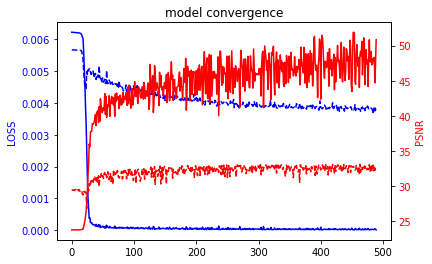

In [ ]:
print(history.history.keys())

fig, ax1 = plt.subplots()
ax1.tick_params(axis='y', labelcolor='blue')
ax1.plot(history.history['val_loss'][10:],'--b',label='LOSS')
ax1.plot(history.history['loss'][10:],'b',label='LOSS')
ax1.set_ylabel('LOSS', color='blue')
#plt.legend(loc='upper left')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('PSNR', color='red')
ax2.plot(history.history['PSNR'][10:],'red',label='PSNR')
ax2.plot(history.history['val_PSNR'][10:],'--r',label='PSNR')
ax2.tick_params(axis='y', labelcolor='red')

plt.xlabel('epoch')
plt.title('model convergence')
#plt.legend(loc='upper right')
plt.show()

In [ ]:
y_predict = network.predict(input_mapping_aniso(COORXYZval,L=L,sampling=sampling))

Text(0.5, 1.0, 'GT-shot 5')

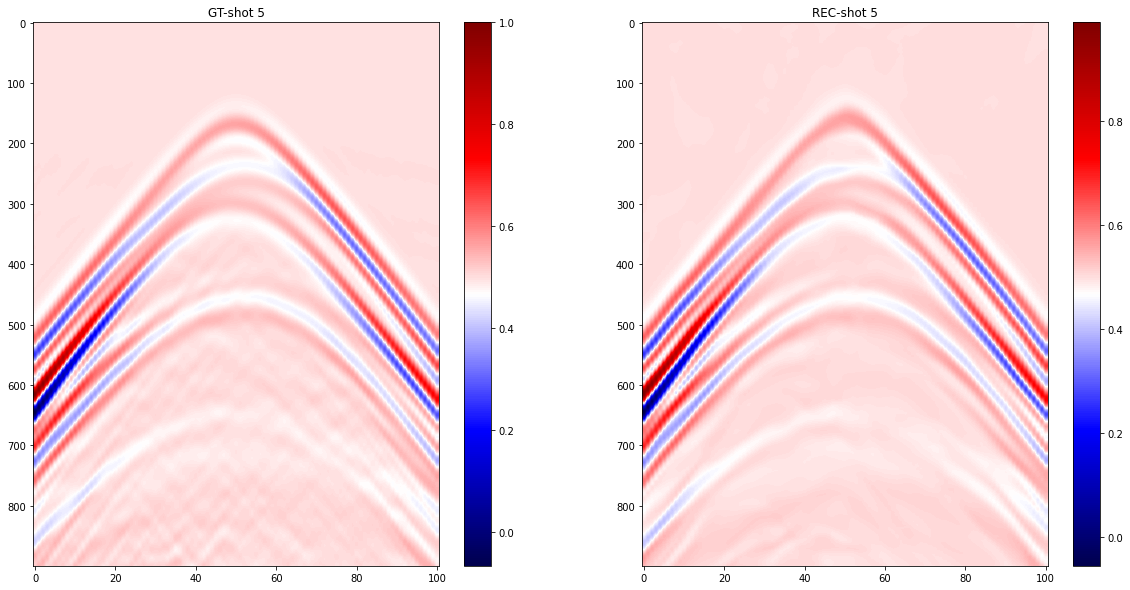

In [ ]:
kk = -4

plt.figure(figsize=(20,10))
plt.subplot(122)
plt.imshow(y_predict.reshape(Data.shape)[:,:,indexDel[kk]],aspect='auto',cmap='seismic'),plt.colorbar()
plt.title('REC-shot '+ str(indexDel[kk]))
plt.subplot(121)
plt.imshow(Data[:,:,indexDel[kk]],aspect='auto',cmap='seismic'), plt.colorbar()
plt.title('GT-shot '+ str(indexDel[kk]))

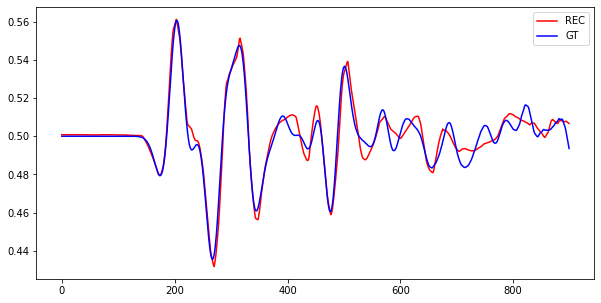

In [ ]:
trace = 40
plt.figure(figsize=(10,5))
plt.plot(y_predict.reshape(Data.shape)[:,trace,indexDel[kk]],'r',label='REC')
plt.plot(Data[:,trace,indexDel[kk]],'b',label='GT')
plt.legend()